# Logistic Regression Consulting Project

## Binary Customer Churn

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out? Create a classification algorithm that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once you've created the model and evaluated it, test out the model on some new data (you can think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).

### Iniciando Spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('LogisticRegressionProject').getOrCreate()

24/10/15 14:25:02 WARN Utils: Your hostname, MacBook-Pro-de-Helena.local resolves to a loopback address: 127.0.0.1; using 192.168.0.34 instead (on interface en0)
24/10/15 14:25:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/15 14:25:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Importando dados

In [2]:
customer = spark.read.csv('customer_churn.csv', inferSchema=True, header=True)
customer.show()

+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|      Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|     

#### Estudando a coluna Company

In [3]:
company_count = customer.groupBy('Company').count()
company_count.orderBy(company_count['count'].desc()).show()

+--------------+-----+
|       Company|count|
+--------------+-----+
|Anderson Group|    4|
|    Wilson PLC|    3|
|  Williams PLC|    3|
|     Evans LLC|    2|
|   Davis Group|    2|
|     Ortiz Ltd|    2|
|     Jones LLC|    2|
|      Rice PLC|    2|
|      Webb PLC|    2|
|  Williams Ltd|    2|
|    Nelson LLC|    2|
|Davis and Sons|    2|
|   Smith Group|    2|
|     Gates Ltd|    2|
|Smith and Sons|    2|
|  Williams LLC|    2|
|      King LLC|    2|
|      Soto PLC|    2|
|    Walker Ltd|    2|
|     Smith Ltd|    2|
+--------------+-----+
only showing top 20 rows



In [4]:
company_count.count()

873

#### Separando o ano e mês da data de onboarding

In [5]:
from pyspark.sql.functions import year, month

customer_year = customer.withColumn('Onboard_year', year(customer['Onboard_date']))
customer_month = customer_year.withColumn('Onboard_month', month(customer_year['Onboard_date']))
customer_month.show()

+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+------------+-------------+
|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|Onboard_year|Onboard_month|
+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+------------+-------------+
|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|        2013|            8|
|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|        2013|            8|
|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|        2016| 

### Separando os dados de treino e teste

In [6]:
train, test = customer_month.randomSplit([0.7, 0.3])

f'O conjunto de treino tem {train.count()} instâncias e o conjunto de teste tem {test.count()} instâncias.'

'O conjunto de treino tem 628 instâncias e o conjunto de teste tem 272 instâncias.'

### Criando um Pipeline

In [7]:
customer_month.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn',
 'Onboard_year',
 'Onboard_month']

#### Assembler

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Onboard_year', 'Onboard_month'],
                            outputCol='features')

#### Criando o modelo

In [9]:
from pyspark.ml.classification import LogisticRegression

logistic_regression = LogisticRegression(labelCol='Churn')

#### Pipeline

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, logistic_regression])

### Treinando o modelo

In [11]:
model = pipeline.fit(train)

24/10/15 14:25:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


### Avaliando

In [12]:
results = model.transform(test)
results.select(['Churn', 'prediction']).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



Área abaixo da curva ROC

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Churn')
auc = evaluator.evaluate(results)
auc

0.720990990990991

Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

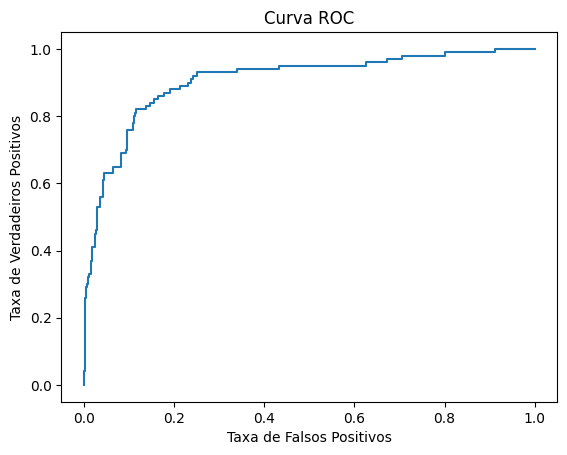

In [14]:
import matplotlib.pyplot as plt

roc = model.stages[1].summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

### Gerando previsões para dados de novos clientes

In [15]:
new_customer = spark.read.csv('new_customers.csv', inferSchema=True, header=True)
new_customer.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|
|  Jeremy Chang|65.0|         100.0|              1|  1.0|     15.0|2006-12-11 07:48:13|085 Austin Views ...|Barron-Robertson|
|Megan Ferguson|32.0|        6487.5|              0|  9.4|     14.0|2016-10-28 05:32:13|922 Wright Branch...|   Sexton-Golden|
|  Taylor Young|32.0|      13147.71|              1| 10.0|      8.0|2012-03-20 00:36:46|Unit 0789 Box 073...|  

In [16]:
new_customer_year = new_customer.withColumn('Onboard_year', year(new_customer['Onboard_date']))
new_customer_month = new_customer_year.withColumn('Onboard_month', month(new_customer_year['Onboard_date']))
new_customer_month.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+------------+-------------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|Onboard_year|Onboard_month|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+------------+-------------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|        2011|            8|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|        2013|            7|
|  Jeremy Chang|65.0|         100.0|              1|  1.0|     15.0|2006-12-11 07:48:13|085 Austin Views ...|Barron-Robertson|        2006|           12|
|Megan Ferguson|32.0|        6487.5|              0|  9.4|     14.0|2016-10-

In [17]:
predictions = model.transform(new_customer_month)
predictions.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|Onboard_year|Onboard_month|            features|       rawPrediction|         probability|prediction|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+------------+-------------+--------------------+--------------------+--------------------+----------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|        2011|            8|[37.0,9935.53,7.7...|[2.71589903009238...|[0.93795831617598...|       0.0|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|

In [18]:
predictions.select(['Names', 'prediction']).show()

+--------------+----------+
|         Names|prediction|
+--------------+----------+
| Andrew Mccall|       0.0|
|Michele Wright|       1.0|
|  Jeremy Chang|       1.0|
|Megan Ferguson|       1.0|
|  Taylor Young|       0.0|
| Jessica Drake|       1.0|
+--------------+----------+

